In [15]:
# Libraries
import os
import sys
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange
from sklearn.datasets import make_moons

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

# For GP
import pyro.contrib.gp as gp

# Default to double precision for torch objects.
torch.set_default_dtype(torch.float64)

ModuleNotFoundError: No module named 'gaussian_processes_util'

In [16]:

def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

def predict(samples, i, X, Xnew, eps=1e-6):
    kernel = gp.kernels.RBF(2, samples['alpha'][i], samples['rho'][i])
    Nnew = Xnew.shape[0]
    
    f = compute_f(samples['alpha'][i],
                  samples['rho'][i],
                  samples['beta'][i],
                  samples['eta'][i], X)
    
    with torch.no_grad():
        gpr = gp.models.GPRegression(X, f, kernel)
        mean, cov = gpr(Xnew, full_cov=True)
        
    fhat = dist.MultivariateNormal(
        mean, cov + torch.eye(Nnew) * eps
    ).sample()
    
    return fhat.sigmoid().numpy()

def plot_data(X, y, **kwargs):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], **kwargs)

def plot_kernel_params(samples, algo, kernel_params=['alpha', 'rho', 'beta'],
                       figsize=(8, 3)):
    plt.figure(figsize=figsize * 1.2)
    for i in range(len(kernel_params)):
        plt.subplot(1, len(kernel_params), i + 1)
        param = kernel_params[i]
        plt.hist(samples[param], bins=30, density=True)
        plt.xlabel(param)
        plt.ylabel('density')
        plt.title(f"Histograhm of {param} ({algo})")
    plt.tight_layout()   

def plot_uq(samples, X, Xnew, algo, figsize=np.array([8, 3])):
    preds = np.stack([predict(samples, i, X, Xnew)
                    for i in trange(samples['rho'].shape[0])])
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
                cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean function ({algo})')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plot_data(X, y, edgecolor="orange")

    plt.subplot(1, 2, 2)
    plt.contourf(x0, x1, preds.std(0).reshape(x0.shape), 101,
                cmap=plt.get_cmap('Oranges'), vmin=0)
    plt.title(f'Posterior SD function ({algo})')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()

    plot_data(X, y, edgecolor="black")

    plot_kernel_params(samples, algo, figsize=figsize)

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
(1025, 30)
(1025,)
(303, 30)
(303,)
torch.Size([1025])


C:\Users\emmab\AppData\Local\Temp\ipykernel_3156\3301591274.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ind_train = torch.tensor(ind_train) # these are indices, therefore they need to be (long) integers


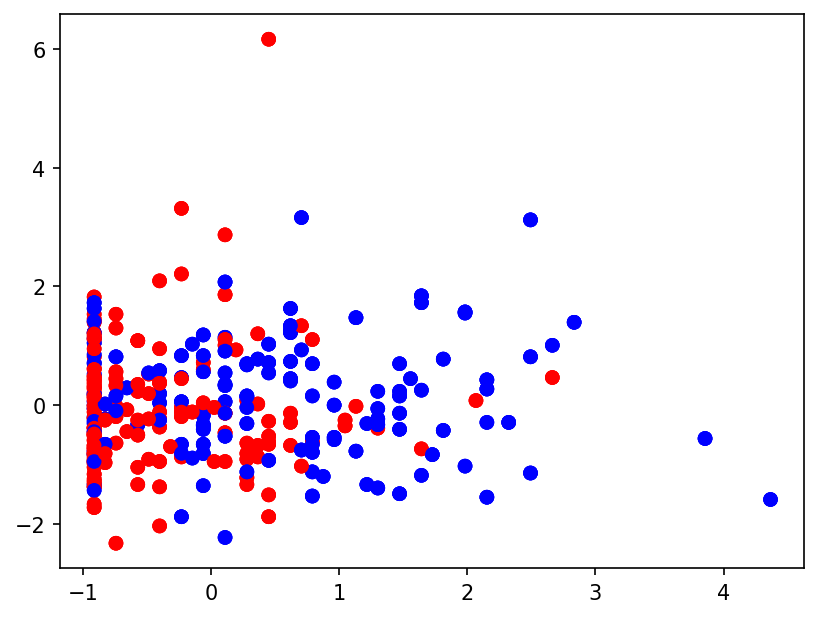

In [20]:
# Make data
# X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)
from func import get_data

# Read data.
X_train,y_train,X_test,y_test,age = get_data()

# Prepare data for Pyro model
n_cat = int(y_train.max())
#print('n_cat', n_cat)
n_ind = ind_train.max()
#print('n_ind', n_ind)
X_train_tensor = torch.tensor(X_train.astype('float')).float()
y_train_tensor = torch.tensor(y_train).float()
#print(y_train_tensor)
ind_train = torch.tensor(ind_train) # these are indices, therefore they need to be (long) integers

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(ind_train.shape)

# Make data
# X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)

X = torch.stack([torch.tensor(X_train[:,4]),
                 torch.tensor(X_train[:,2])], axis=-1)
y = torch.tensor(y_train)

# Make prediction grid.
Xnew, x0, x1 = gen_grid(X, 30, return_each=True, eps=0.5)
Xnew = torch.from_numpy(Xnew)

plot_data(X, y)


In [22]:
def sq_exp_kernel(d, alpha, rho):
    return alpha * alpha * torch.exp(-0.5 * torch.pow(d / rho, 2))

def compute_f(alpha, rho, beta, eta, X):
    N = X.shape[0]
    D = torch.cdist(X, X)
    K = sq_exp_kernel(D, alpha, rho) + torch.eye(N) * 1e-6
    L = K.cholesky()
    return L.matmul(eta) + beta

# GP Binary Classifier.
def gpc(X, y):
    N = y.shape[0]
    
    # Priors.
    alpha = pyro.sample('alpha', dist.LogNormal(0, 1))
    rho = pyro.sample('rho', dist.LogNormal(0, 1))
    beta = pyro.sample('beta', dist.Normal(0, 1))

    with pyro.plate('latent_response', N):
        eta = pyro.sample('eta', dist.Normal(0, 1))

    # Latent function.
    f = compute_f(alpha, rho, beta, eta, X)
   
    with pyro.plate('response', N):
        pyro.sample('obs', dist.Bernoulli(logits=f), obs=y)

In [23]:

%%time

### HMC ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(2)

# Set up HMC sampler.
kernel = HMC(gpc, step_size=0.05, trajectory_length=1, 
             adapt_step_size=False, adapt_mass_matrix=False, jit_compile=True)
hmc = MCMC(kernel, num_samples=500, warmup_steps=500)
hmc.run(X, y.double())

# Get posterior samples
hmc_posterior_samples = hmc.get_samples()

Warmup:   0%|          | 0/1000 [00:00, ?it/s]C:\Users\emmab\AppData\Local\Temp\ipykernel_3156\3660559884.py:8: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  L = K.cholesky()
c:\Users\emmab\anaconda3\lib\site-packages\pyro\poutine\subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other 

CPU times: total: 1h 2min 8s
Wall time: 37min 39s


100%|██████████| 500/500 [01:16<00:00,  6.51it/s]


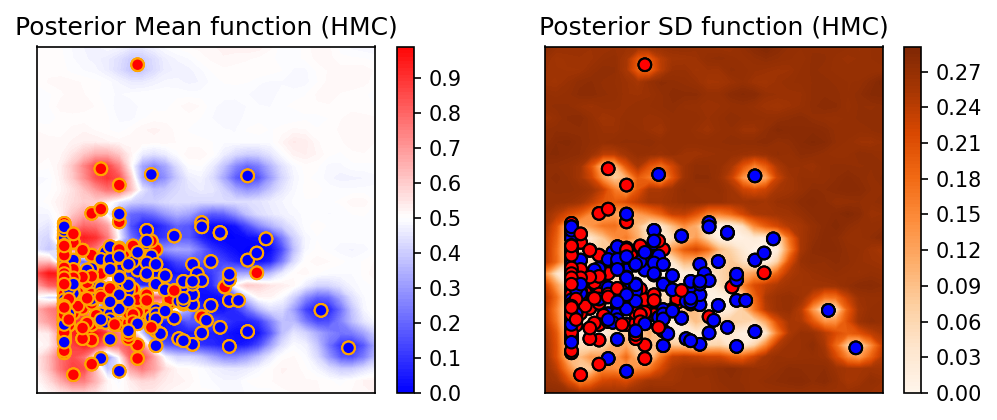

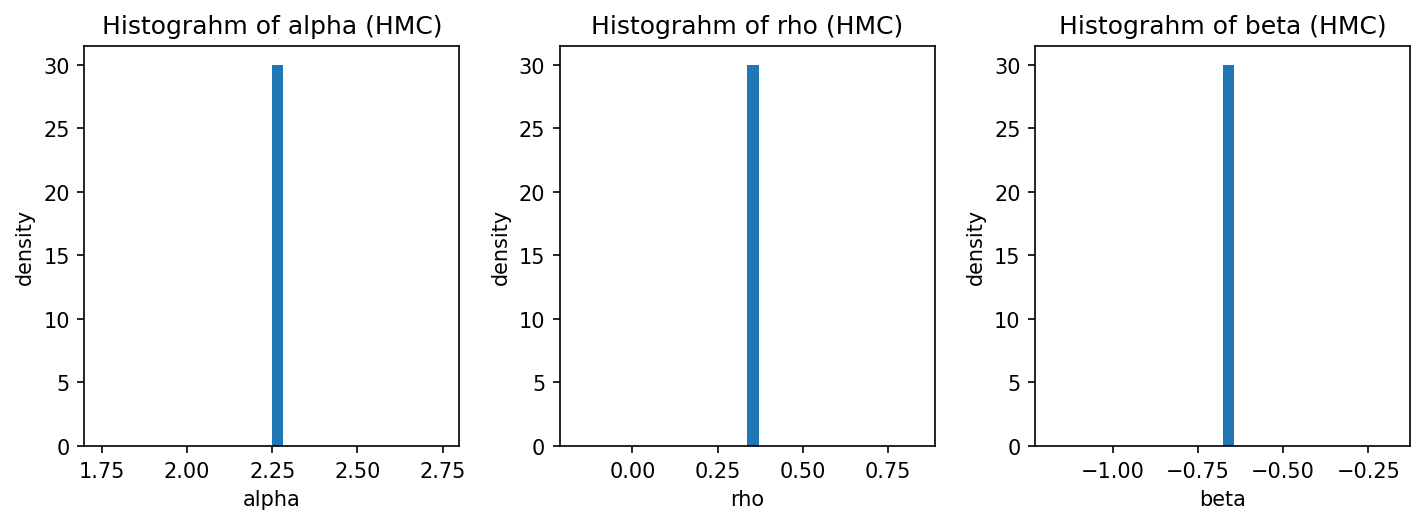

In [24]:
plot_uq(hmc_posterior_samples, X, Xnew, "HMC")
